In [1]:
%load_ext tensorboard

from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import time
import timm
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision import transforms as T
import tqdm # This is optional but useful

#
# Reproducibility
#
# Much from https://pytorch.org/docs/stable/notes/randomness.html
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
torch.manual_seed(0)
#torch.use_deterministic_algorithms(True)
# For DataLoaders
g = torch.Generator().manual_seed(0)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adapted from:
# https://github.com/tjmoon0104/pytorch-tiny-imagenet/blob/master/AlexNet.ipynb
data_transforms = {
    'train': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'val': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'test': T.Compose([
        T.Resize(299), T.ToTensor(),
    ])
}

data_dir = os.path.join(
    os.path.dirname(os.path.abspath("")),
    "Project",
    "tiny-imagenet-200"
)
num_workers = {
    'train' : 4,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
train_dataset = image_datasets["train"]
test_dataset = image_datasets["val"]
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             #num_workers=num_workers[x], shuffle=True)
              #for x in ['train', 'val', 'test']}
#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [3]:
#
# Adapted from Stephen's ModelExamples
#
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
#train = dataloaders["train"]

#dataiter = iter(train)
#imgs, labels = next(dataiter)
#img_grid = torchvision.utils.make_grid(imgs)
#imgs, labels = imgs.to(device), labels.to(device)
#matplotlib_imshow(img_grid)

In [4]:
# Weight of the stability objective
ALPHA = 0.01

CLASS_NUMBER = len(image_datasets["train"].classes)

In [5]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (
            tensor
            + torch.empty(tensor.size(), device=device).normal_() * self.std
            + self.mean
        )
    
    def __repr__(self):
        return (
            self.__class__.__name__
            + '(mean={0}, std={1})'.format(self.mean, self.std)
        )
    
    
class StabilityTrainingModel(torch.nn.Module):
    def __init__(self, other_model, perturbation=None):
        """
        Wraps another model to allow for stability training. May specify
        custom perturbation transformation.
        """
        super().__init__()
        self.model = other_model
        
        if perturbation is None:
            self.perturb = AddGaussianNoise(0, 0.04)
        else:
            self.perturb = perturbation
    
    def forward(self, x):
        """Apply the model to some input."""
        return torch.cat((
            self.model(x), self.model(self.perturb(x))
        ), 1)
            
            
# This will act like a class
def RobustInception():
    """Retrieve a fresh stability trained Inception v3 Network."""
    bare_inception = torchvision.models.inception_v3(
        pretrained=True,
        aux_logits=False
    )
    for param in bare_inception.parameters():
        param.requires_grad = False
    bare_inception.fc = nn.Linear(2048, CLASS_NUMBER)
    
    inception = nn.Sequential(bare_inception, nn.Sigmoid())
    return StabilityTrainingModel(inception)

In [6]:
training_objective = nn.CrossEntropyLoss()

stability_loss = nn.CrossEntropyLoss()

def full_loss(outputs, label):
    clean_output, distort_output = torch.split(outputs, CLASS_NUMBER, 1)
    return (
        training_objective(clean_output, label)
        + ALPHA * stability_loss(distort_output, clean_output)
    )

In [7]:
def _easy_worker_init_fn(worker_id : int):
    """
    Sets the seed of the worker to depend on the initial seed. Credit to
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


#
# This class will make recording information easier
#
class TrainResult:
    """
    Hold the results of a training round. Basically a nice wrapper.

    Losses and accuracies should be averages over a batch for plot
    labels to make sense.

    Use whichever storage makes sense, but if one doesn't use the
    storage then don't expect the corresponding plots to do anything.
    """

    def __init__(self, model):
        """
        Constructor - prepare local variables. Include model since the
        one provided to trainer will likely be moved to a different
        device. Provide the one that is actually trained here, and then
        it can be used.
        """
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_accuracy_history = []
        self.test_accuracy_history = []
        self.time_training = 0.0
        self.time_testing = 0.0
        self.model = model

    def plot_loss_train_valid_curves(self, ax, show_legend : bool=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_loss_history, label="Train")
        ax.plot(self.test_loss_history, label="Test")
        ax.title(f"Model Loss")
        ax.xlabel("Iteration")
        ax.ylabel("Average Batch Loss")
        if show_legend:
            ax.legend()

    def plot_accuracy_train_valid_curves(self):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_accuracy_history, label="Train")
        ax.plot(self.test_accuracy_history, label="Test")
        ax.title(f"Model Accuracy")
        ax.xlabel("Iteration")
        ax.ylabel("Average Batch Accuracy")
        if show_legend:
            ax.legend()

    def print_time_info(self):
        """Prints some lines with information about timing."""
        print(f"Spent {round(self.time_training)} seconds training.")
        print(f"Spent {round(self.time_testing)} seconds evaluating.")

    def full_analysis(self):
        """Display all analysis plots and print time information."""
        if len(self.train_loss_history) > 0:
            self.plot_loss_train_valid_curves()
        if len(self.train_accuracy_history) > 0:
            self.plot_accuracy_train_valid_curves()
        if self.time_training > 0.0:
            self.print_time_info()

    def save(self, save_filename_func, count : int=0):
        """
        Uses the save_filename_func provided with the count to create
        files that save the models current weights and the training
        progress so far.

        For count, 0 is by convention the final version.
        """
        # Save model
        torch.save(model.state_dict(), save_filename_func(count, True))
        # Save progress
        with open(save_filename_func(count, False), "wb") as file_obj:
            pickle.dump(
                {
                    "train_loss_history" : self.train_loss_history,
                    "test_loss_history" : self.test_loss_history,
                    "train_accuracy_history" : self.train_accuracy_history,
                    "test_accuracy_history" : self.test_accuracy_history,
                    "time_training" : self.time_training,
                    "time_testing" : self.time_testing
                }, file_obj
            )


def _def_save_filename(iteration_number : int, is_model : bool):
    """
    Returns a save filename from an iteration number, and whether the
    thing being saved is the model or the loss progress.
    """
    # Make sure inputs are okay (no directory traversal attacks!)
    if not isinstance(iteration_number, int):
        raise TypeError("Iteration number should be an integer.")

    # Retrieve proper name
    if is_model:
        return os.path.join(
            os.path.dirname(os.path.abspath("")),
            f"model_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
        )
    return os.path.join(
        os.path.dirname(os.path.abspath("")),
        f"progress_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
    )


def _def_get_accuracy(model_output, labels):
    """
    Given model output and labels, finds the average accuracy over the 
    batch.
    """
    preds = model_output.topk(1, dim=1)[1].t().flatten()
    return (preds == labels).sum() / len(preds)

class Trainer:
    """
    Has methods for setting training and testing data, the model, and
    training the model.
    """

    def __init__(self, model):
        """Creates a trainer for a specific model."""
        self._model = model

        self._set_device(torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ))

        # Just a class, will need to freshly call in order to use
        self._optimizer = optim.RMSprop
        # With these parameters after model parameters
        self._optimizer_parameters = {
            "lr" : 1e-4 # Learning rate
        }

        self._loss_function = full_loss

        self._loader_workers = 4
        self._worker_init_fn = _easy_worker_init_fn

        self._save_period = 2
        self._save_filename_func = _def_save_filename

        self._get_accuracy_func = _def_get_accuracy

    def _set_device(self, dev : torch.device):
        """Helper to set device to dev."""
        self._device = dev

        self._model.to(self._device)

    def train(self,
        training_dataset,
        testing_dataset,
        batch_size=256,
        nepochs=4
    ):
        """
        Given a training and testing dataset, how large of batches to 
        extract from them, and the number of epochs to train for, trains
        the models and saves data along the way.
        """
        # Let's get some local variables for brevity
        model = self._model
        optimizer = self._optimizer(
            model.parameters(),
            **self._optimizer_parameters
        )
        loss_func = self._loss_function
        device = self._device

        # Prepare loaders
        def get_loader_from_set(dataset):
            return torch.utils.data.DataLoader(
                dataset,
                batch_size = batch_size,
                num_workers = self._loader_workers,
                worker_init_fn = self._worker_init_fn,
                shuffle = True
            )

        training_loader = get_loader_from_set(training_dataset)
        testing_loader = get_loader_from_set(testing_dataset)

        # Prepare progress bar
        tqdm_variant = tqdm.tqdm # Assume not in Jupyter
        try:
            # Credit https://stackoverflow.com/a/39662359
            shell_name = get_ipython().__class__.__name__
            if shell_name == "ZMQInteractiveShell":
                # Case in Jupyter
                tqdm_variant = tqdm.notebook.tqdm
        except NameError:
            # Probably no iPhython instance, just use standard
            pass

        # Return value
        result = TrainResult(model)
      
        loss = torch.Tensor([0])
        count = 0
        # Credit Steven's notebook for most of this code
        for epoch in tqdm_variant(
            range(nepochs),
            desc=f"Epoch",
            unit="epoch",
            disable=False
        ):
            # Training step
            model.train()
            start = time.perf_counter()
            for (imgs, labels) in tqdm_variant(
                training_loader,
                desc="Training Iteration",
                unit="%",
                disable=False
            ):
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)
                
                # Prepare relevant variables
                imgs, labels = imgs.to(self._device), labels.to(self._device)
                out = model(imgs)
                
                # Determine loss
                loss = loss_func(out, labels)

                # Store intermediate results - note average over batch
                result.train_loss_history.append(loss.item())
                result.train_accuracy_history.append(
                    self._get_accuracy_func(out, labels)                 
                )
                
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
            end = time.perf_counter()
            result.time_training += end - start

            # Testing step
            model.eval()
            start = time.perf_counter()
            with torch.no_grad(): # Don't need gradients
                for (imgs, labels) in tqdm_variant(
                    testing_loader,
                    desc="Testing Iteration",
                    unit="%",
                    disable=False
                ):
                    # Prepare relevant variables
                    imgs, labels = imgs.to(self._device), labels.to(self._device)

                    out = model(imgs)
                    
                    # Determine loss
                    loss = loss_func(out, labels)

                    # Store intermediate results - note average over batch
                    result.test_loss_history.append(loss.item())
                    result.test_accuracy_history.append(
                        self._get_accuracy_func(out, labels)                 
                    )
            end = time.perf_counter()
            result.time_testing += end - start
          
            # Save
            count += 1
            if count % self._save_period == 0:
                result.save(self._save_filename_func, count)

            # Print the last loss calculated and the epoch
            print(f"\nEpoch {epoch}: Loss: {loss.item()}")

        return result

    @property
    def model(self):
        return self._model

    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, value):
        if isinstance(value, torch.device):
            self._set_device(value)
            return
        elif isinstance(value, str):
            # This may throw an error, in which case purpose achieved
            self._set_device(torch.device(value))
            return
        # Only accept those two types
        raise ValueError("Device must be a torch.device or string.")

    @property
    def optimizer(self):
        return self._optimizer

    @optimizer.setter
    def optimizer(self, value):
        if not isinstance(value, type):
            raise ValueError("Optimizer must be a class. Perhaps you "\
                "tried to assign an instantiated object?")
        if not hasattr(value, "step"):
            raise ValueError("Optimizer classes must have a step method.")
        if not hasattr(value, "zero_grad"):
            raise ValueError("Optimizer classes must have a zero_grad method.")
        # Presumably safe if we get here
        self._optimizer = value

    @property
    def optimizer_params(self):
        # Danger here: non-string key may be added to parameters
        return self._optimizer_params

    @optimizer_params.setter
    def optimizer_params(self, value):
        if not isinstance(value, dict):
            raise ValueError("Optimizer parameters should be a "\
                "dictionary of values.")
        # Iterate through keys
        for k in value:
            if not isinstance(k, str):
                raise ValueError("All keys in parameter dictionary must "\
                    "be strings.")
        # Presumably safe if we get here
        self._optimizer_params = value

    @property
    def loss_function(self):
        return self._loss_function

    @loss_function.setter
    def loss_function(self, value):
        # Danger here: this only verifies that it is a function
        if callable(value):
            self._loss_function = value
            return
        # If get here, definitely won't work
        raise ValueError("Loss function must be a function.")

    @property
    def loader_workers(self):
        return self._loader_workers

    @loader_workers.setter
    def loader_workers(self, value):
        if isinstance(value, int):
            self._loader_workers = value
            return
        # If get here, definitely won't work
        raise ValueError("Loader worker count must be an integer.")

    @property
    def worker_init_fn(self):
        return self._worker_init_fn

    @worker_init_fn.setter
    def worker_init_fn(self, value):
        # Danger here: this only verifies that it is a function
        if callable(value):
            self._worker_init_fn = value
            return
        # If get here, definitely won't work
        raise ValueError("Worker initialization function must be a function.")

    @property
    def save_period(self):
        return self._save_period

    @save_period.setter
    def save_period(self, value):
        if isinstance(value, int):
            self._save_period = value
            return
        # If get here, definitely won't work
        raise ValueError("Save period must be an integer.")

    @property
    def save_filename_func(self):
        return self._save_filename_func

    @save_filename_func.setter
    def save_filename_func(self, value):
        # Danger here: this only verifies that it is a function
        if callable(value):
            self._save_filename_func = value
            return
        # If get here, definitely won't work
        raise ValueError("Save filename function must be a function.")

    @property
    def get_accuracy_func(self):
        return self._get_accuracy_func

    @get_accuracy_func.setter
    def get_accuracy_func(self, value):
        # Danger here: this only verifies that it is a function
        if callable(value):
            self._get_accuracy_func = value
            return
        # If get here, definitely won't work
        raise ValueError("Get accuracy function must be a function.")

In [8]:
model = RobustInception()

In [9]:
def class_get_accuracy(model_output, labels):
    """For stability trained classifier, finds the accuracy"""
    return (
        torch.sum(
            torch.split(
                model_output, CLASS_NUMBER, 1
            )[0].topk(1, dim=1)[1].t().flatten()
            == labels
        )
        / len(model_output)
   )
    
classifier_trainer = Trainer(model)
classifier_trainer.loader_workers = 0
classifier_trainer.get_accuracy_func = class_get_accuracy

In [10]:
result = classifier_trainer.train(train_dataset, test_dataset, 256, 2)

Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

Training Iteration:   0%|          | 0/391 [00:00<?, ?%/s]

Testing Iteration:   0%|          | 0/40 [00:00<?, ?%/s]


Epoch 0: Loss: 5.3167924880981445


Training Iteration:   0%|          | 0/391 [00:00<?, ?%/s]

Testing Iteration:   0%|          | 0/40 [00:00<?, ?%/s]


Epoch 1: Loss: 5.299319744110107


In [46]:
bare_inception = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)
#for param in bare_inception.parameters():
    #param.requires_grad = False
bare_inception.fc = nn.Linear(2048, CLASS_NUMBER)

no_stable_model = nn.Sequential(bare_inception, nn.Sigmoid())

In [47]:
no_stable_class_trainer = Trainer(model)
no_stable_class_trainer.loader_workers = 0
no_stable_class_trainer.loss_function = training_objective

In [48]:
no_stable_result = no_stable_class_trainer.train(train_dataset, test_dataset, 256, 2)

Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

Training Iteration:   0%|          | 0/391 [00:00<?, ?%/s]

Testing Iteration:   0%|          | 0/40 [00:00<?, ?%/s]


Epoch 0: Loss: 5.923317909240723


Training Iteration:   0%|          | 0/391 [00:00<?, ?%/s]

Testing Iteration:   0%|          | 0/40 [00:00<?, ?%/s]


Epoch 1: Loss: 5.722001552581787


In [45]:
bare_inception = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)
next(iter(bare_inception.fc.parameters()))

Parameter containing:
tensor([[-0.0086, -0.0398, -0.0185,  ...,  0.0549, -0.0039, -0.0181],
        [ 0.0284, -0.0138,  0.0174,  ..., -0.0356, -0.0229, -0.0194],
        [ 0.0229,  0.0438,  0.0014,  ..., -0.0127, -0.0096,  0.0516],
        ...,
        [ 0.0166, -0.0316,  0.0269,  ...,  0.0601, -0.0179,  0.0774],
        [-0.0199,  0.0340, -0.0111,  ..., -0.0469,  0.0140, -0.0049],
        [-0.0011,  0.0912, -0.0061,  ..., -0.0014,  0.0127,  0.0157]],
       requires_grad=True)

In [39]:
next(iter(no_stable_result.model.model[0].fc.parameters()))

Parameter containing:
tensor([[ 2.0852e-03,  8.8458e-03, -1.7417e-02,  ..., -2.8292e-02,
         -6.1834e-03,  1.5350e-02],
        [-1.4591e-02,  1.7513e-02, -2.4140e-05,  ..., -1.5278e-02,
         -3.1952e-02,  2.0212e-03],
        [-2.4531e-02,  2.2425e-02, -4.9494e-04,  ..., -2.6571e-02,
         -2.7933e-02, -1.6415e-02],
        ...,
        [-6.5589e-03, -3.1275e-02, -3.7634e-02,  ..., -4.6080e-02,
         -3.5795e-02, -2.1592e-02],
        [-4.9436e-02, -4.0869e-02, -2.8899e-02,  ..., -3.7413e-02,
         -4.3961e-02, -2.7601e-02],
        [-2.7793e-02, -2.5812e-02, -6.3794e-03,  ...,  1.3707e-03,
         -2.3833e-02,  1.2131e-03]], device='cuda:0', requires_grad=True)

In [42]:
next(iter(no_stable_model[0].fc.parameters()))

Parameter containing:
tensor([[ 0.0001, -0.0149,  0.0188,  ...,  0.0157, -0.0026,  0.0167],
        [-0.0186, -0.0106, -0.0095,  ...,  0.0019, -0.0012,  0.0125],
        [-0.0056, -0.0160,  0.0186,  ...,  0.0091,  0.0021,  0.0141],
        ...,
        [-0.0114,  0.0085, -0.0137,  ...,  0.0209, -0.0023, -0.0196],
        [-0.0095, -0.0042,  0.0186,  ...,  0.0093,  0.0201, -0.0167],
        [-0.0164, -0.0033, -0.0147,  ...,  0.0164, -0.0015,  0.0011]],
       requires_grad=True)

In [19]:

# Let's set up some parameters
learning_rate=0.01
momentum=0.9
nepochs = 1

# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# We also need a loss function
LossFunction = full_loss

# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
cnt = 0
for epoch in tqdm.tqdm(range(nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm.tqdm(train,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        # PyTorch is Magic!
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
        cnt += 1
        print(f"\r{cnt:3}/{len(train)}", end="")
        if cnt == 15:
            break
    print(f"\nEpoch {epoch}: loss: {loss.item()}")

Epoch:   0%|                                                                                  | 0/1 [00:00<?, ?epoch/s]

  9/391

Epoch:   0%|                                                                                  | 0/1 [00:32<?, ?epoch/s]


KeyboardInterrupt: 

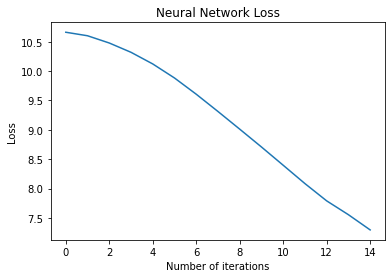

In [51]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

In [45]:
#list(model.parameters())[-3:]
#optimizer.state.values()
training_objective(torch.split(out, 200, 1)[1], label)
#stability_loss(torch.split(out, 200, 1)[1], torch.split(out, 200, 1)[0])

tensor(1.1672e+09, device='cuda:0', grad_fn=<NllLossBackward0>)

In [46]:
torch.split(out, 200, 1)[1]

tensor([[-91006096., -91006096., -91005536.,  ..., -91006152., -91006152.,
         -91004984.],
        [-62418420., -62418420., -62418252.,  ..., -62418436., -62418436.,
         -62418108.],
        [-89301576., -89301576., -89301192.,  ..., -89301576., -89301576.,
         -89301000.],
        ...,
        [-85520720., -85520720., -85520296.,  ..., -85520720., -85520720.,
         -85520088.],
        [-84133248., -84133296., -84132800.,  ..., -84133344., -84133344.,
         -84132600.],
        [-74545936., -74545968., -74545800.,  ..., -74545968., -74545968.,
         -74545168.]], device='cuda:0', grad_fn=<SplitBackward0>)

In [ ]:
validation = dataloaders["val"]
for data, label in validation:
    data = data.to(device)
    labels = labels.to(device)
    out = model(data)
    print(torch.sum(torch.split(out, 200, 1)[0].topk(1, dim=1)[1].t().flatten() == labels) / len(out))

In [83]:
len(out)

256

In [8]:
imgs.max()

tensor(1., device='cuda:0')

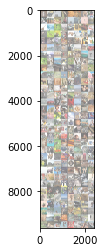

In [5]:
valid = dataloaders["val"]

dataiter = iter(valid)
imgs, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(imgs)
imgs, labels = imgs.to(device), labels.to(device)
matplotlib_imshow(img_grid)

In [6]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [8]:
val_ldr = torch.utils.data.DataLoader(image_datasets["val"], batch_size=128, num_workers=0, shuffle=True)

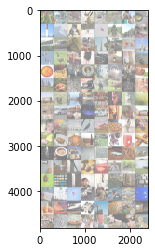

In [9]:
dataiter = iter(val_ldr)
imgs, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(imgs)
imgs, labels = imgs.to(device), labels.to(device)
matplotlib_imshow(img_grid)

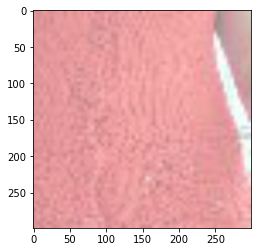

In [35]:
matplotlib_imshow(imgs[16].cpu())

In [11]:
labels[16]

tensor(162, device='cuda:0')

In [7]:
# Adapted from https://github.com/DennisHanyuanXu/Tiny-ImageNet/blob/master/src/data_prep.py
def create_val_img_folder(args):
    '''
    This method is responsible for separating validation images into separate sub folders
    '''
    dataset_dir = os.path.join(args["data_dir"], args["dataset"])
    val_dir = os.path.join(dataset_dir, 'val')
    img_dir = os.path.join(val_dir, 'images')

    fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
    data = fp.readlines()
    val_img_dict = {}
    for line in data:
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]
    fp.close()

    # Create folder if not present and move images into proper folders
    for img, folder in val_img_dict.items():
        newpath = (os.path.join(img_dir, folder))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        if os.path.exists(os.path.join(img_dir, img)):
            os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))
            
# Using it
args = {
    "data_dir" : r"C:\Users\Gabriel\Documents\Winter2022\CIS472\Project",
    "dataset" : r"tiny-imagenet-200"
}
#create_val_img_folder(args)

In [7]:
class TripletRankingDataset(torch.utils.data.Dataset):
    def __init__(self,
                 img_dir : str,
                 pos_per_img : int,
                 neg_per_pos : int,
                 transform=None
                ):
        """
        Point at directory which has subdirectories corresponding to
        each class. Supply the number of positive images per image in
        the subdirectories and the number of negative images to combine
        with.
        """
        if transform is None:
            transform = nn.Identity()
        self.transform = transform
        self.mode = "RGB"#ImageReadMode.RGB
        
        #
        # Initialize triplets
        #
        self.triplets = [ ]
        
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
        for subdir_path in subdirectories_paths:
            img_per_class = len(os.listdir(subdir_path))
            break
        randoms = np.random.randint(
            0,
            img_per_class,
            (
                len(subdirectories_paths),
                img_per_class,
                pos_per_img,
                neg_per_pos + 1 # Last for positive selection
            ),
            dtype="int16"
        )
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            # Iterate over images
            for img_idx, img in enumerate(os.listdir(subdir_path)):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    pos_rand = randoms[subdir_idx][img_idx][pos_it][-1]
                    # Adjust on equal
                    if pos_rand == pos_it:
                        if pos_rand == 0:
                            pos_rand += 1
                        else:
                            pos_rand -= 1
                    # Form name
                    pos_path = os.path.join(
                        subdir_path,
                        f"{class_names[subdir_idx]}_{pos_rand}.JPEG"
                    )
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        neg_rand = randoms[subdir_idx][img_idx][pos_it][neg_it]
                        # Form name
                        neg_path = os.path.join(
                            neg_class_path,
                            f"{neg_class}_{neg_rand}.JPEG"
                        )
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
        
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        this_triplet = self.triplets[idx]
        #query = self.transform(read_image(this_triplet[0], self.mode))
        #positive = self.transform(read_image(this_triplet[1], self.mode))
        #negative = self.transform(read_image(this_triplet[2], self.mode))
        query = self.transform(Image.open(this_triplet[0]).convert(self.mode))
        positive = self.transform(Image.open(this_triplet[1]).convert(self.mode))
        negative = self.transform(Image.open(this_triplet[2]).convert(self.mode))
        return query, positive, negative

In [8]:
normalize_img = T.Lambda(lambda x : x/255)
this_transform = T.Compose([T.Resize(299), normalize_img])
this_path = os.path.join(os.path.abspath(""), "tiny-imagenet-200\\train")
trd = TripletRankingDataset(this_path, 2, 2, transform=this_transform)
test_path = os.path.join(os.path.abspath(""), "tiny-imagenet-200\\test")
trd_test = TripletRankingDataset(this_path, 1, 1, transform=this_transform)

In [74]:
pic_iter = iter(trd)

In [8]:
def show_triplet(triplet):
    a, b, c = triplet.split(3)
    ToPIL = T.ToPILImage() # Converting function
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(ToPIL(a))
    ax[1].imshow(ToPIL(b))
    ax[2].imshow(ToPIL(c))
    fig.show()

In [16]:
batch_size = 32
loaders = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(trd_test, batch_size=batch_size,
                                     num_workers=0)

In [77]:
batch = next(iter(loaders)).to("cuda")

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_6580/3426435285.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


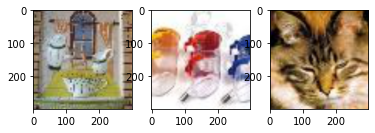

In [78]:
show_triplet(batch[2])

In [55]:
reshaped = torch.split(batch, 3, 1)

In [59]:
a, b,c = reshaped
print(a.shape, b.shape, c.shape)

torch.Size([128, 3, 299, 299]) torch.Size([128, 3, 299, 299]) torch.Size([128, 3, 299, 299])


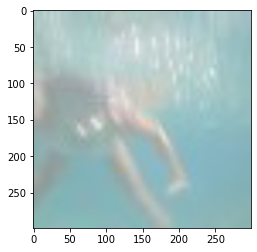

In [65]:
matplotlib_imshow(a[2].cpu())

In [9]:
class TripletRanker(nn.Module):
    """Triplet ranking model."""
    
    def __init__(self, model):
        """Creates a triplet ranker out of the model."""
        super().__init__()
        self.model = model
        
    def forward(self, queries, positives, negatives):
        """Send batch of triplets through."""
        queries_encode = self.model(queries)
        positives_encode = self.model(positives)
        negatives_encode = self.model(negatives)
        return queries_encode, positives_encode, negatives_encode

We'll train feature ranking

In [12]:
bare_inception = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)
for param in bare_inception.parameters():
    param.requires_grad = False
bare_inception.fc = nn.Linear(2048, 16)

model = TripletRanker(bare_inception).to(device)

In [13]:
optimizer = optim.Adam(model.parameters())

In [20]:
# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

# Return value
triplet_result = TrainResult(model)
triplet_loss = nn.TripletMarginLoss(1.0, 2)

loss = torch.Tensor([0])
count = 0
# Credit Steven's notebook for most of this code
for epoch in tqdm_variant(
    range(2),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    print()
    # Training step
    model.train()
    start = time.perf_counter()
    for imgs in tqdm_variant(
        loaders,
        desc="Training Iteration",
        unit="%",
        disable=False
    ):
        # Prepare optimizer
        optimizer.zero_grad(set_to_none=True)

        # Prepare relevant variables
        imgs = imgs.to(device)
        out = model(imgs)

        # Determine loss
        #loss = model.loss(*out).sum()
        loss = triplet_loss(*out)

        # Store intermediate results - note average over batch
        print("\r", loss.item(), end="")
        triplet_result.train_loss_history.append(loss.item())

        loss.backward() # Get gradients
        optimizer.step() # Descend gradients
    end = time.perf_counter()
    triplet_result.time_training += end - start
    print()

    # Testing step
    print()
    model.eval()
    start = time.perf_counter()
    with torch.no_grad(): # Don't need gradients
        for (imgs, labels) in tqdm_variant(
            test_loader,
            desc="Testing Iteration",
            unit="%",
            disable=False
        ):
            # Prepare relevant variables
            imgs = imgs.to(device)
            out = model(imgs)

            # Determine loss
            #loss = model.loss(*out).sum()
            loss = triplet_loss(*out)
            print("\r", loss.item(), end="")

            # Store intermediate results - note average over batch
            triplet_result.test_loss_history.append(loss.item())
    end = time.perf_counter()
    triplet_result.time_testing += end - start
    print()

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Loss: {loss.item()}")

Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

Training Iteration:   0%|          | 0/12500 [00:00<?, ?%/s]

 0.17528961598873138



Testing Iteration:   0%|          | 0/3125 [00:00<?, ?%/s]

ValueError: too many values to unpack (expected 2)

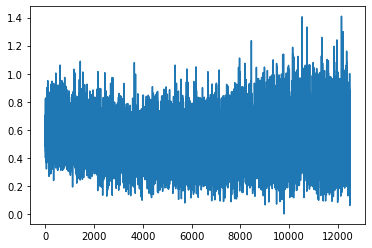

In [21]:
plt.plot(triplet_result.train_loss_history)

We'll create plots

In [8]:
class jpegCompressor():
    def __init__(self):
        """Copmpress jpeg image down to quality level, "qlty_level" """
        self.image_fpath = None
        self.qlty_level = None
        self.outfile = None

    def compress(self, image_fpath, outfile, qlty_level=100):
        img = Image.open(image_fpath)
        img.save(outfile, 
                 "JPEG", 
                 optimize = True, 
                 quality = qlty_level)
        return 
    
def make_observations(baseline_model, stabilized_model, imagefolder):
    """
    Given a model trained for triplet ranking, make duplicate detection
    observations.
    """
    baseline_observations = []
    stabilized_observations = []
    
    compressor = jpegCompressor()
    for img_name in os.listdir(imagefolder):
        #
        # Deal with images
        #
        original_img = Image.open(image_fpath)
        # Thanks https://stackoverflow.com/a/30771751
        buffer = StringIO.StringIO()
        original_img.save(buffer, "JPEG", optimize=True, quality=50)
        compressed_img = Image.open(buffer)
        
        orig_tensor = T.ToTensor(original_img)
        comp_tensor = T.ToTensor(compressed_img)
        #
        # Make observations
        #
        baseline_model.eval()
        stabilized_model.eval()
        with torch.no_grad():
            # Baseline
            original_rep = baseline_model(orig_tensor)
            compressed_rep = baseline_model(comp_tensor)
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            baseline_observations.append(dist)
            # Stabilized
            original_rep = stabilized_model(orig_tensor)
            compressed_rep = stabilized_model(comp_tensor)
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            stabilized_observations.append(dist)
            
    return baseline_observations, stabilized_observations
        
def plot_cumulative_dist(
    baseline_observations,
    stabilized_observations
):
    """Plot our reproduction of Figure 7."""
    fig, ax = plt.subplots()
    ax.set_title("Cumulative Distributions")
    ax.set_xlabel("Feature Distance")
    ax.set_ylabel("Cumulative Fraction")
    ax.hist(
        baseline_observations,
        round(np.sqrt(len(baseline_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Baseline"
    )
    ax.hist(
        stabilized_observations,
        round(np.sqrt(len(stabilized_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Stabilized"
    )
    ax.legend()
    fig.show()
    
def plot_precision_vs_quality(
    qualities,
    baseline_precision,
    stabilized_precision
):
    """Plots precision vs quality as in Figure 9."""
    fig, ax = plt.subplots()
    ax.set_title("Precision vs Quality")
    ax.set_xlabel("JPEG Quality")
    ax.set_ylabel("Precision@top-1")
    plt.plot(qualities, baseline_precision, label="Baseline")
    plt.plot(qualities, stabilized_precision, label="Stabilized")
    ax.legend()
    fig.show()

Alternate test: have dataset load from memory first, then access from with __getitem__. Also, DataLoaders are smart enough to stack things if we return a tuple from the dataset.

Let's try training ResNet18, since that tends to go quicker.

In [9]:
resnet_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = os.path.join(os.path.abspath(""), "tiny-imagenet-200")
class_dataset_train = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=resnet_transform
)
class_dataset_val = datasets.ImageFolder(
    os.path.join(data_dir, "val"),
    transform=resnet_transform
)

batch_size = 64
loaders = torch.utils.data.DataLoader(
    class_dataset_train,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    class_dataset_val,
    batch_size=batch_size,
    num_workers=0
)

In [34]:
resnet = torchvision.models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
    
resnet.fc = nn.Linear(512, 200, bias=True)

resnet = resnet.to(device)

In [35]:
optimizer = optim.SGD(resnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

In [36]:
resnet_loss = nn.CrossEntropyLoss()

In [37]:
resnet_result = TrainResult(optimizer)

In [38]:
CLASS_NUMBER = 200

# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

def train_epoch(model, loader, optimizer, device, loss_func, result):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    # Training step
    model.train()
    start = time.perf_counter()
    for imgs, labels in tqdm_variant(
        loader,
        desc="Training Iteration",
        disable=False
    ):
        # Prepare optimizer
        optimizer.zero_grad(set_to_none=True)

        # Prepare relevant variables
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)

        # Determine loss
        loss = loss_func(out, labels)

        # Store intermediate results - note average over batch
        item = loss.item()
        avg_loss += item
        result.train_loss_history.append(item)
        
        # Calculate accuracy
        acc = (
            torch.sum(
                out.topk(1, dim=1)[1].t().flatten() == labels
            ) / len(out)
        ).item()
        result.train_accuracy_history.append(acc)

        loss.backward() # Get gradients
        optimizer.step() # Descend gradients
    end = time.perf_counter()
    result.time_training += end - start
    
    return avg_loss / len(loader)
    
def test_epoch(model, loader, device, loss_func, result):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    # Testing step
    model.eval()
    start = time.perf_counter()
    with torch.no_grad(): # Don't need gradients
        for imgs, labels in tqdm_variant(
            loader,
            desc="Testing Iteration",
            disable=False
        ):
            # Prepare relevant variables
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)

            # Determine loss
            loss = loss_func(out, labels)
            
            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            result.test_loss_history.append(item)
            
            # Calculate accuracy
            acc = (
                torch.sum(
                    out.topk(1, dim=1)[1].t().flatten() == labels
                ) / len(out)
            ).item()
            result.test_accuracy_history.append(acc)
    end = time.perf_counter()
    result.time_testing += end - start
    
    return avg_loss / len(loader)

In [26]:
# Train for some number of epochs
EPOCH_COUNT = 140
SAVE_PERIOD = 4

best_loss = 10000
best_count = 0
for epoch in tqdm_variant(
    range(EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = train_epoch(
        resnet,
        loaders,
        optimizer,
        device,
        resnet_loss,
        resnet_result
    )

    # Test
    val_loss = test_epoch(
        resnet,
        test_loader,
        device,
        resnet_loss,
        resnet_result
    )
    
    # Update scheduling
    scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < best_loss:
        torch.save(
            resnet, 
            os.path.join(
                os.path.abspath(""),
                f"best_resnet_classifier_{best_count}_{int(time.time())}.pt"
            )
        )
        best_count += 1
        
    if epoch % SAVE_PERIOD == SAVE_PERIOD - 1:
        torch.save(
            resnet,
            os.path.join(
                os.path.abspath(""),
                f"resnet_classifier_{epoch}_{int(time.time())}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Train Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

Current Learning Rate: 0.01


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 0: Train Loss: 4.174787683206267, Validation Loss: 3.242102487831359
Current Learning Rate: 0.01


Training Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Iteration:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1: Train Loss: 2.8855036224071138, Validation Loss: 2.5472920897659983


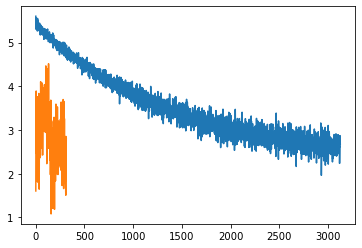

In [27]:
plt.plot(resnet_result.train_loss_history)
plt.plot(resnet_result.test_loss_history)
plt.show()

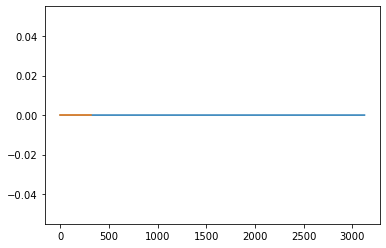

In [28]:
plt.plot(resnet_result.train_accuracy_history)
plt.plot(resnet_result.test_accuracy_history)
plt.show()

In [33]:
#torch.save(resnet, os.path.join(os.path.abspath(""), "first_resnet.pt"))

Triplet ranking:

In [11]:
resnet_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_path = os.path.join(os.path.abspath(""), "tiny-imagenet-200\\train")
test_path = os.path.join(os.path.abspath(""), "tiny-imagenet-200\\val")
trd = TripletRankingDataset(train_path, 2, 2, transform=resnet_transform)
trd_test = TripletRankingDataset(test_path, 1, 1, transform=resnet_transform)

batch_size = 32
loaders = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(trd_test, batch_size=batch_size,
                                     num_workers=0)

In [12]:
resnet_encoder = torchvision.models.resnet18(pretrained=True)

for param in resnet_encoder.parameters():
    param.requires_grad = False
    
resnet_encoder.fc = nn.Linear(512, 64, bias=True) # 64-Dimensional Encoding

resnet_triplet_ranking = TripletRanker(resnet_encoder).to(device)

In [13]:
optimizer = optim.SGD(resnet_triplet_ranking.parameters(), lr=0.002, momentum=0.9)

In [24]:
# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

# Return value
resnet_encoder_result = TrainResult(resnet_triplet_ranking)
resnet_encoder_loss = nn.TripletMarginLoss(1.0, 2)

loss = torch.Tensor([0])
best_loss = 10000
best_count = 0
count = 0
# Credit Steven's notebook for most of this code
for epoch in tqdm_variant(
    range(1),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Training step
    resnet_triplet_ranking.train()
    start = time.perf_counter()
    for queries, positives, negatives in tqdm_variant(
        loaders,
        desc="Training Iteration",
        unit="%",
        disable=False
    ):
        # Prepare optimizer
        optimizer.zero_grad(set_to_none=True)

        # Prepare relevant variables
        queries = queries.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        out = resnet_triplet_ranking(queries, positives, negatives)

        # Determine loss
        loss = resnet_encoder_loss(*out)

        # Store intermediate results - note average over batch
        item = loss.item()
        resnet_encoder_result.train_loss_history.append(item)

        loss.backward() # Get gradients
        optimizer.step() # Descend gradients
    end = time.perf_counter()
    resnet_encoder_result.time_training += end - start

    ## Testing step
    #resnet_encoder.eval()
    #start = time.perf_counter()
    #with torch.no_grad(): # Don't need gradients
        #for queries, positives, negatives in tqdm_variant(
            #test_loader,
            #desc="Testing Iteration",
            #unit="%",
            #disable=False
        #):
            ## Prepare relevant variables
            #queries = queries.to(device)
            #positives = positives.to(device)
            #negatives = negatives.to(device)
            #out = resnet_triplet_loss(queries, positives, negatives)
#
            ## Determine loss
            #loss = resnet_encoder_loss(out)
            #
            #item = loss.item()
#
            ## Store intermediate results - note average over batch
            #resnet_encoder_result.test_loss_history.append(item)
    #end = time.perf_counter()
    #resnet_encoder_result.time_testing += end - start
    
    if loss < best_loss:
        torch.save(resnet_triplet_ranking, os.path.join(os.path.abspath(""), f"best_resnettriplet_{best_count}_{int(time.time())}.pt"))
        best_count += 1
        
    torch.save(resnet_triplet_ranking, os.path.join(os.path.abspath(""), f"resnettriplet_{epoch}_{int(time.time())}.pt"))

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Loss: {loss.item()}")

Epoch:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training Iteration:   0%|          | 0/12500 [00:00<?, ?%/s]


Epoch 0: Loss: 0.3398042619228363


In [16]:
loss

tensor(0.6133, device='cuda:0', grad_fn=<MeanBackward0>)

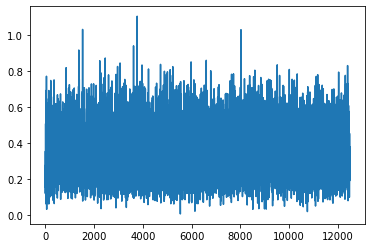

In [25]:
plt.plot(resnet_encoder_result.train_loss_history[::])

In [20]:
torch.save(resnet_triplet_ranking, os.path.join(os.path.abspath(""), f"resnettriplet_erred.pt"))

In [29]:
batch = next(iter(loaders))
q, p, n = batch[0][0], batch[0][1], batch[0][2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


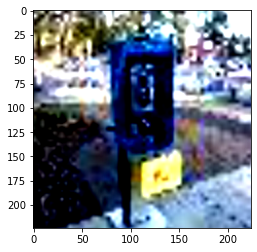

In [35]:
matplotlib_imshow(n)

In [38]:
with torch.no_grad():
    output = resnet_triplet_ranking(*map(lambda x : x.to(device) ,batch))

In [45]:
qfeat = output[0][0]

In [46]:
pfeat = output[0][1]

In [49]:
nfeat = output[0][2]

In [48]:
torch.sqrt(((qfeat - pfeat)**2).sum())

tensor(11.7238, device='cuda:0')

In [50]:
torch.sqrt(((qfeat - nfeat)**2).sum())

tensor(10.8814, device='cuda:0')